In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os 
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Plan

1. Delete feature:
- high correlated value
- delete low importance feature with PCA ?
2. Feature Engineering:
- Create new features (time related, Fourier ?)
- Feature = stationary + seasonality + noise
3. Missing Value:
- mean or KNN-Imputation
4. Data transformation:
- Feature: One-hot-encoding for idx and more
- Feature: Apply transformation Box Cox, (log, ^2, 1/,...)
- Y: Apply transformation too!
- Feature: Normalize (MinMax, StandardScaler, Robust)
- X_Estimated: Apply shift between estimated and observed
5. ImBalance Data (too much zero to forecast)
- Build 2 models, one binary classification, and another one for y>0 prediction
6. Training-set:
- Separate in three sets (time is increasing)
- Train only on the spring ?


# Data Import : 

Data import

In [3]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
train_a = pd.read_parquet('A/train_targets.parquet')

X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')

X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

Set new index, and delete the old one.

In [4]:
X_train_estimated_a.set_index('date_forecast', inplace = True)
X_train_observed_a.set_index('date_forecast', inplace = True)
X_test_estimated_a.set_index('date_forecast', inplace = True)

X_train_estimated_b.set_index('date_forecast', inplace = True)
X_train_observed_b.set_index('date_forecast', inplace = True)
X_test_estimated_b.set_index('date_forecast', inplace = True)

X_train_estimated_c.set_index('date_forecast', inplace = True)
X_train_observed_c.set_index('date_forecast', inplace = True)
X_test_estimated_c.set_index('date_forecast', inplace = True)


X_train_estimated_a.drop('date_calc', axis=1, inplace=True)
X_test_estimated_a.drop('date_calc', axis=1, inplace=True)

X_train_estimated_b.drop('date_calc', axis=1, inplace=True)
X_test_estimated_b.drop('date_calc', axis=1, inplace=True)

X_train_estimated_c.drop('date_calc', axis=1, inplace=True)
X_test_estimated_c.drop('date_calc', axis=1, inplace=True)


train_a.set_index('time', inplace = True)
train_b.set_index('time', inplace = True)
train_c.set_index('time', inplace = True)

train_a.dropna(inplace = True)
train_b.dropna(inplace = True)
train_c.dropna(inplace = True)

Match the size of X and Y. We create X_train_estimated_S_matched, X_train_observed_S_matched, train_S_estimated_matched, train_S_observed_matched

In [5]:
X_train_estimated_a = X_train_estimated_a.loc[X_train_estimated_a.index[::4]]
X_train_observed_a = X_train_observed_a.loc[X_train_observed_a.index[::4]]
X_test_estimated_a = X_test_estimated_a.loc[X_test_estimated_a.index[::4]]


X_train_estimated_b = X_train_estimated_b.loc[X_train_estimated_b.index[::4]]
X_train_observed_b = X_train_observed_b.loc[X_train_observed_b.index[::4]]
X_test_estimated_b = X_test_estimated_b.loc[X_test_estimated_b.index[::4]]

X_train_estimated_c = X_train_estimated_c.loc[X_train_estimated_c.index[::4]]
X_train_observed_c = X_train_observed_c.loc[X_train_observed_c.index[::4]]
X_test_estimated_c = X_test_estimated_c.loc[X_test_estimated_c.index[::4]]

In [6]:
#We match the sizes of X and Y 
#We keep the measurements from every hour only 
intersection_index_estimated_a = X_train_estimated_a.index.intersection(train_a.index)
intersection_index_estimated_b = X_train_estimated_b.index.intersection(train_b.index)
intersection_index_estimated_c = X_train_estimated_c.index.intersection(train_c.index)

intersection_index_observed_a = X_train_observed_a.index.intersection(train_a.index)
intersection_index_observed_b = X_train_observed_b.index.intersection(train_b.index)
intersection_index_observed_c = X_train_observed_c.index.intersection(train_c.index)


X_train_estimated_a = X_train_estimated_a.loc[intersection_index_estimated_a]
X_train_estimated_b = X_train_estimated_b.loc[intersection_index_estimated_b]
X_train_estimated_c = X_train_estimated_c.loc[intersection_index_estimated_c]


X_train_observed_a = X_train_observed_a.loc[intersection_index_observed_a]
X_train_observed_b = X_train_observed_b.loc[intersection_index_observed_b]
X_train_observed_c = X_train_observed_c.loc[intersection_index_observed_c]


train_a_estimated = train_a.loc[intersection_index_estimated_a]
train_b_estimated = train_b.loc[intersection_index_estimated_b]
train_c_estimated = train_c.loc[intersection_index_estimated_c]

train_a_observed = train_a.loc[intersection_index_observed_a]
train_b_observed = train_b.loc[intersection_index_observed_b]
train_c_observed = train_c.loc[intersection_index_observed_c]

In [7]:
train_a_observed.shape

(29667, 1)

In [8]:
X_train_estimated_a.shape

(4394, 45)

# 1. Delete feature:
- high correlated value
- constant values
- delete low importance feature with PCA ?

## high correlated value

In [9]:
corr_matrix = X_train_observed_a.corr().abs()
high_corr_var=np.where(corr_matrix>0.95)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('absolute_humidity_2m:gm3', 'dew_point_2m:K'),
 ('clear_sky_energy_1h:J', 'clear_sky_rad:W'),
 ('diffuse_rad:W', 'diffuse_rad_1h:J'),
 ('direct_rad:W', 'direct_rad_1h:J'),
 ('msl_pressure:hPa', 'pressure_100m:hPa'),
 ('msl_pressure:hPa', 'pressure_50m:hPa'),
 ('msl_pressure:hPa', 'sfc_pressure:hPa'),
 ('pressure_100m:hPa', 'pressure_50m:hPa'),
 ('pressure_100m:hPa', 'sfc_pressure:hPa'),
 ('pressure_50m:hPa', 'sfc_pressure:hPa')]

In [10]:
to_drop = ['absolute_humidity_2m:gm3', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 
           'direct_rad_1h:J', 'total_cloud_cover:p', 
           'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']

In [11]:
#Delete features because high correlation between them (>0.9) : 
X_train_estimated_a.drop(to_drop, axis=1, inplace=True)
X_train_estimated_b.drop(to_drop, axis=1, inplace=True)
X_train_estimated_c.drop(to_drop, axis=1, inplace=True)

X_train_observed_a.drop(to_drop, axis=1, inplace=True)
X_train_observed_b.drop(to_drop, axis=1, inplace=True)
X_train_observed_c.drop(to_drop, axis=1, inplace=True)
    
X_test_estimated_a.drop(to_drop, axis=1, inplace=True)
X_test_estimated_b.drop(to_drop, axis=1, inplace=True)
X_test_estimated_c.drop(to_drop, axis=1, inplace=True)

In [12]:
X_train_estimated_a.shape[1]

37

## constant values

Drop features that are constant for each station.

In [13]:
constant_values_a = ['snow_drift:idx', 'snow_density:kgm3', 'elevation:m']
constant_values_b = ['snow_density:kgm3', 'elevation:m']
constant_values_c = ['snow_density:kgm3', 'elevation:m']

In [14]:
#Delete because constant values:
X_train_estimated_a.drop(constant_values_a, axis=1, inplace=True)
X_train_observed_a.drop(constant_values_a, axis=1, inplace=True)
X_test_estimated_a.drop(constant_values_a, axis=1, inplace=True)

X_train_estimated_b.drop(constant_values_b, axis=1, inplace=True)
X_train_observed_b.drop(constant_values_b, axis=1, inplace=True)
X_test_estimated_b.drop(constant_values_b, axis=1, inplace=True)
    
X_train_estimated_c.drop(constant_values_c, axis=1, inplace=True)
X_train_observed_c.drop(constant_values_c, axis=1, inplace=True)
X_test_estimated_c.drop(constant_values_c, axis=1, inplace=True)

## delete low importance feature with PCA ?

We can also delete more features...

In [15]:
# and more
#to_drop = ['feature_name']

Attempt with PCA

# 2. Feature Engineering:
- Create new features (time related, Fourier ?)
- Feature = stationary + seasonality + noise

In [16]:
# and more 

In [17]:
#We change the Time that is a string, to a variable in seconds 
timestamp_s_observed_a = X_train_observed_a.index.map(pd.Timestamp.timestamp)
timestamp_s_observed_b = X_train_observed_b.index.map(pd.Timestamp.timestamp)
timestamp_s_observed_c = X_train_observed_c.index.map(pd.Timestamp.timestamp)

timestamp_s_estimated_a = X_train_estimated_a.index.map(pd.Timestamp.timestamp)
timestamp_s_estimated_b = X_train_estimated_b.index.map(pd.Timestamp.timestamp)
timestamp_s_estimated_c = X_train_estimated_c.index.map(pd.Timestamp.timestamp)

timestamp_s_test_a = X_test_estimated_a.index.map(pd.Timestamp.timestamp)
timestamp_s_test_b = X_test_estimated_b.index.map(pd.Timestamp.timestamp)
timestamp_s_test_c = X_test_estimated_c.index.map(pd.Timestamp.timestamp)

#Then, we incorporate the periodicity
day = 24*60*60
year = (365.2425)*day

X_train_observed_a['Day sin'] = np.sin(timestamp_s_observed_a * (2 * np.pi / day))
X_train_observed_a['Day cos'] = np.cos(timestamp_s_observed_a * (2 * np.pi / day))
X_train_observed_a['Year sin'] = np.sin(timestamp_s_observed_a * (2 * np.pi / year))
X_train_observed_a['Year cos'] = np.cos(timestamp_s_observed_a * (2 * np.pi / year))

X_train_observed_b['Day sin'] = np.sin(timestamp_s_observed_b * (2 * np.pi / day))
X_train_observed_b['Day cos'] = np.cos(timestamp_s_observed_b * (2 * np.pi / day))
X_train_observed_b['Year sin'] = np.sin(timestamp_s_observed_b * (2 * np.pi / year))
X_train_observed_b['Year cos'] = np.cos(timestamp_s_observed_b * (2 * np.pi / year))

X_train_observed_c['Day sin'] = np.sin(timestamp_s_observed_c * (2 * np.pi / day))
X_train_observed_c['Day cos'] = np.cos(timestamp_s_observed_c * (2 * np.pi / day))
X_train_observed_c['Year sin'] = np.sin(timestamp_s_observed_c * (2 * np.pi / year))
X_train_observed_c['Year cos'] = np.cos(timestamp_s_observed_c * (2 * np.pi / year))


X_train_estimated_a['Day sin'] = np.sin(timestamp_s_estimated_a * (2 * np.pi / day))
X_train_estimated_a['Day cos'] = np.cos(timestamp_s_estimated_a * (2 * np.pi / day))
X_train_estimated_a['Year sin'] = np.sin(timestamp_s_estimated_a * (2 * np.pi / year))
X_train_estimated_a['Year cos'] = np.cos(timestamp_s_estimated_a * (2 * np.pi / year))

X_train_estimated_b['Day sin'] = np.sin(timestamp_s_estimated_b * (2 * np.pi / day))
X_train_estimated_b['Day cos'] = np.cos(timestamp_s_estimated_b * (2 * np.pi / day))
X_train_estimated_b['Year sin'] = np.sin(timestamp_s_estimated_b * (2 * np.pi / year))
X_train_estimated_b['Year cos'] = np.cos(timestamp_s_estimated_b * (2 * np.pi / year))

X_train_estimated_c['Day sin'] = np.sin(timestamp_s_estimated_c * (2 * np.pi / day))
X_train_estimated_c['Day cos'] = np.cos(timestamp_s_estimated_c * (2 * np.pi / day))
X_train_estimated_c['Year sin'] = np.sin(timestamp_s_estimated_c * (2 * np.pi / year))
X_train_estimated_c['Year cos'] = np.cos(timestamp_s_estimated_c * (2 * np.pi / year))


X_test_estimated_a['Day sin'] = np.sin(timestamp_s_test_a * (2 * np.pi / day))
X_test_estimated_a['Day cos'] = np.cos(timestamp_s_test_a * (2 * np.pi / day))
X_test_estimated_a['Year sin'] = np.sin(timestamp_s_test_a * (2 * np.pi / year))
X_test_estimated_a['Year cos'] = np.cos(timestamp_s_test_a * (2 * np.pi / year))

X_test_estimated_b['Day sin'] = np.sin(timestamp_s_test_b * (2 * np.pi / day))
X_test_estimated_b['Day cos'] = np.cos(timestamp_s_test_b * (2 * np.pi / day))
X_test_estimated_b['Year sin'] = np.sin(timestamp_s_test_b * (2 * np.pi / year))
X_test_estimated_b['Year cos'] = np.cos(timestamp_s_test_b * (2 * np.pi / year))

X_test_estimated_c['Day sin'] = np.sin(timestamp_s_test_c * (2 * np.pi / day))
X_test_estimated_c['Day cos'] = np.cos(timestamp_s_test_c * (2 * np.pi / day))
X_test_estimated_c['Year sin'] = np.sin(timestamp_s_test_c * (2 * np.pi / year))
X_test_estimated_c['Year cos'] = np.cos(timestamp_s_test_c * (2 * np.pi / year))


(<Axes: >,)

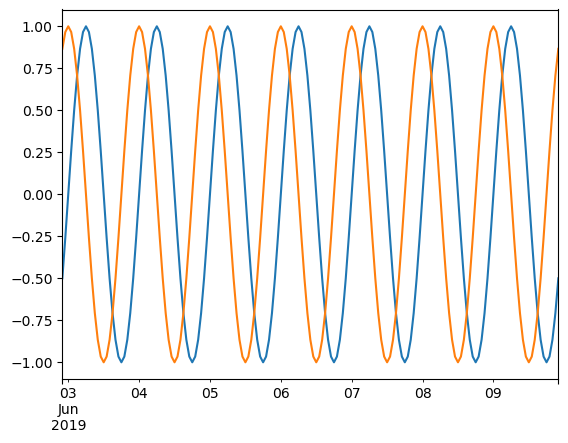

In [18]:
X_train_observed_a['Day sin'].loc['2019-06-02 22:00:00':'2019-06-09 22:00:00'].plot(),
X_train_observed_a['Day cos'].loc['2019-06-02 22:00:00':'2019-06-09 22:00:00'].plot(),

(<Axes: >,)

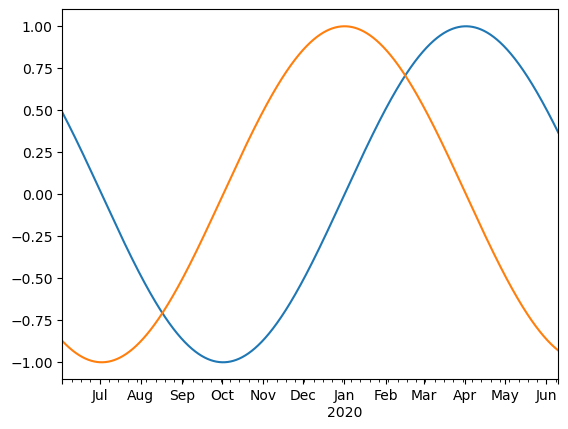

In [19]:
X_train_observed_a['Year sin'].loc['2019-06-02 22:00:00':'2020-06-09 22:00:00'].plot(),
X_train_observed_a['Year cos'].loc['2019-06-02 22:00:00':'2020-06-09 22:00:00'].plot(),

In [20]:
#We change the sun_azimuth variable, because an angle in degree is not really comprehensible for the machine (0 and 360 should be the same)
#therefore, we introduce the sinus and cosinus features
X_train_observed_a['sun_azimuth_cos:'] = np.cos(X_train_observed_a['sun_azimuth:d'])
X_train_observed_a['sun_azimuth_sin:'] = np.sin(X_train_observed_a['sun_azimuth:d'])
X_train_estimated_a['sun_azimuth_cos:'] = np.cos(X_train_estimated_a['sun_azimuth:d'])
X_train_estimated_a['sun_azimuth_sin:'] = np.sin(X_train_estimated_a['sun_azimuth:d'])
X_test_estimated_a['sun_azimuth_cos:'] = np.cos(X_test_estimated_a['sun_azimuth:d'])
X_test_estimated_a['sun_azimuth_sin:'] = np.sin(X_test_estimated_a['sun_azimuth:d'])
X_train_observed_a.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_train_estimated_a.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_test_estimated_a.drop(['sun_azimuth:d'], axis = 1, inplace = True)


X_train_observed_b['sun_azimuth_cos:'] = np.cos(X_train_observed_b['sun_azimuth:d'])
X_train_observed_b['sun_azimuth_sin:'] = np.sin(X_train_observed_b['sun_azimuth:d'])
X_train_estimated_b['sun_azimuth_cos:'] = np.cos(X_train_estimated_b['sun_azimuth:d'])
X_train_estimated_b['sun_azimuth_sin:'] = np.sin(X_train_estimated_b['sun_azimuth:d'])
X_test_estimated_b['sun_azimuth_cos:'] = np.cos(X_test_estimated_b['sun_azimuth:d'])
X_test_estimated_b['sun_azimuth_sin:'] = np.sin(X_test_estimated_b['sun_azimuth:d'])
X_train_observed_b.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_train_estimated_b.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_test_estimated_b.drop(['sun_azimuth:d'], axis = 1, inplace = True)

X_train_observed_c['sun_azimuth_cos:'] = np.cos(X_train_observed_c['sun_azimuth:d'])
X_train_observed_c['sun_azimuth_sin:'] = np.sin(X_train_observed_c['sun_azimuth:d'])
X_train_estimated_c['sun_azimuth_cos:'] = np.cos(X_train_estimated_c['sun_azimuth:d'])
X_train_estimated_c['sun_azimuth_sin:'] = np.sin(X_train_estimated_c['sun_azimuth:d'])
X_test_estimated_c['sun_azimuth_cos:'] = np.cos(X_test_estimated_c['sun_azimuth:d'])
X_test_estimated_c['sun_azimuth_sin:'] = np.sin(X_test_estimated_c['sun_azimuth:d'])
X_train_observed_c.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_train_estimated_c.drop(['sun_azimuth:d'], axis = 1, inplace = True)
X_test_estimated_c.drop(['sun_azimuth:d'], axis = 1, inplace = True)

(<Axes: >,)

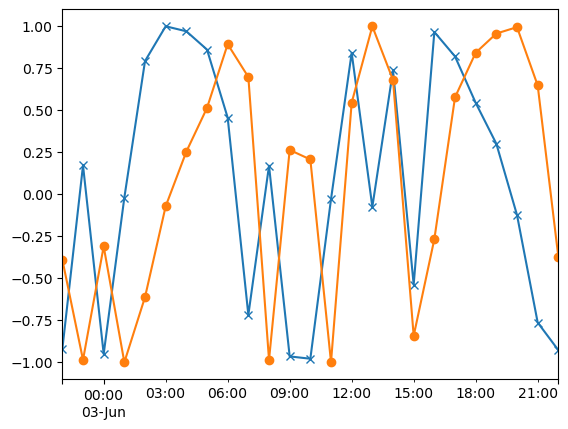

In [21]:
X_train_observed_a['sun_azimuth_cos:'].loc['2019-06-02 22:00:00':'2019-06-03 22:00:00'].plot(marker='x'),
X_train_observed_a['sun_azimuth_sin:'].loc['2019-06-02 22:00:00':'2019-06-03 22:00:00'].plot(marker='o'),

# 3. Missing Value:
- mean or KNN-Imputation

For the missing values, we fill with differents methods such as : 0, mean, KNN-Imputer.

## Mean

In [22]:
X_train_estimated_a.isna().mean().sort_values(ascending=False)[:3]*100

ceiling_height_agl:m    25.967228
cloud_base_agl:m        13.791534
wind_speed_10m:ms        0.000000
dtype: float64

In [23]:
#Missing values
value={'ceiling_height_agl:m' : X_train_estimated_a['ceiling_height_agl:m'].mean(),
       'cloud_base_agl:m' : -999#X_train_estimated_a['cloud_base_agl:m'].mean()
      }

X_train_estimated_a = X_train_estimated_a.fillna(value=value)
X_train_observed_a = X_train_observed_a.fillna(value=value)
X_test_estimated_a = X_test_estimated_a.fillna(value=value)

X_train_estimated_b = X_train_estimated_b.fillna(value=value)
X_train_observed_b = X_train_observed_b.fillna(value=value)
X_test_estimated_b = X_test_estimated_b.fillna(value=value)

X_train_estimated_c = X_train_estimated_c.fillna(value=value)
X_train_observed_c = X_train_observed_c.fillna(value=value)
X_test_estimated_c = X_test_estimated_c.fillna(value=value)

In [24]:
X_train_estimated_a.isna().mean().sort_values(ascending=False)[:3]*100

air_density_2m:kgm3    0.0
wind_speed_10m:ms      0.0
snow_depth:cm          0.0
dtype: float64

<Axes: >

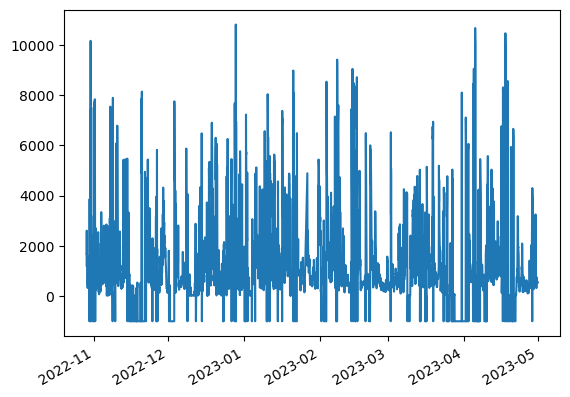

In [25]:
X_train_estimated_a['cloud_base_agl:m'].plot()

# 4. Data transformation:
- Feature: One-hot-encoding for idx and more
- Feature: Apply transformation Box Cox, (log, ^2, 1/,...)
- Y: Apply transformation too!
- Feature: Normalize (MinMax, StandardScaler, Robust)
- X_Estimated: Apply shift between estimated and observed

## one-hot-encoding

We apply _one-hot-encoder_, for categorials features. We saw that 'rain_water:kgm2' is also a categorial feature.

In [26]:
#One Hot encoding 
from sklearn.preprocessing import OneHotEncoder

idx_a = ['dew_or_rime:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'rain_water:kgm2']
idx_b_c = ['dew_or_rime:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx', 'rain_water:kgm2']


for id in idx_a:
    concatenated_df = pd.concat([X_train_observed_a[id], X_train_estimated_a[id], X_test_estimated_a[id]])
    one_hot_encoded = pd.get_dummies(concatenated_df, prefix= id)
    
    df_estimated_encoded = one_hot_encoded.loc[X_train_estimated_a.index]
    df_observed_encoded = one_hot_encoded.loc[X_train_observed_a.index]
    df_test_encoded = one_hot_encoded.loc[X_test_estimated_a.index]
    
    X_train_observed_a = pd.concat([X_train_observed_a, df_observed_encoded], axis =1)
    X_train_estimated_a = pd.concat([X_train_estimated_a, df_estimated_encoded], axis = 1)
    X_test_estimated_a = pd.concat([X_test_estimated_a, df_test_encoded], axis = 1)
    
    X_train_observed_a.drop([id], inplace = True, axis=1)
    X_train_estimated_a.drop([id], inplace = True, axis=1)
    X_test_estimated_a.drop([id], inplace = True, axis=1)
    
for id in idx_b_c:
    concatenated_df = pd.concat([X_train_observed_b[id], X_train_estimated_b[id], X_test_estimated_b[id]])
    one_hot_encoded = pd.get_dummies(concatenated_df, prefix= id)
    
    df_estimated_encoded = one_hot_encoded.loc[X_train_estimated_b.index]
    df_observed_encoded = one_hot_encoded.loc[X_train_observed_b.index]
    df_test_encoded = one_hot_encoded.loc[X_test_estimated_b.index]
    
    X_train_observed_b = pd.concat([X_train_observed_b, df_observed_encoded], axis =1)
    X_train_estimated_b = pd.concat([X_train_estimated_b, df_estimated_encoded], axis = 1)
    X_test_estimated_b = pd.concat([X_test_estimated_b, df_test_encoded], axis = 1)
    
    X_train_observed_b.drop([id], inplace = True, axis=1)
    X_train_estimated_b.drop([id], inplace = True, axis=1)
    X_test_estimated_b.drop([id], inplace = True, axis=1)
    
for id in idx_b_c:
    concatenated_df = pd.concat([X_train_observed_c[id], X_train_estimated_c[id], X_test_estimated_c[id]])
    one_hot_encoded = pd.get_dummies(concatenated_df, prefix= id)
    
    df_estimated_encoded = one_hot_encoded.loc[X_train_estimated_c.index]
    df_observed_encoded = one_hot_encoded.loc[X_train_observed_c.index]
    df_test_encoded = one_hot_encoded.loc[X_test_estimated_c.index]
    
    X_train_observed_c = pd.concat([X_train_observed_c, df_observed_encoded], axis =1)
    X_train_estimated_c = pd.concat([X_train_estimated_c, df_estimated_encoded], axis = 1)
    X_test_estimated_c = pd.concat([X_test_estimated_c, df_test_encoded], axis = 1)
    
    X_train_observed_c.drop([id], inplace = True, axis=1)
    X_train_estimated_c.drop([id], inplace = True, axis=1)
    X_test_estimated_c.drop([id], inplace = True, axis=1)

In [27]:
X_train_observed_a.iloc[:,34:].head()

,sun_azimuth_sin:,dew_or_rime:idx_-1.0,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,is_in_shadow:idx_0.0,is_in_shadow:idx_1.0,precip_type_5min:idx_0.0,precip_type_5min:idx_1.0,precip_type_5min:idx_2.0,precip_type_5min:idx_3.0,precip_type_5min:idx_5.0,precip_type_5min:idx_6.0,rain_water:kgm2_0.0,rain_water:kgm2_0.10000000149011612,rain_water:kgm2_0.20000000298023224,rain_water:kgm2_0.30000001192092896,rain_water:kgm2_0.4000000059604645,rain_water:kgm2_0.5,rain_water:kgm2_0.6000000238418579,rain_water:kgm2_0.699999988079071,rain_water:kgm2_0.8999999761581421,rain_water:kgm2_1.0,rain_water:kgm2_1.399999976158142
2019-06-02 22:00:00,-0.389801,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-06-02 23:00:00,-0.985375,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-06-03 00:00:00,-0.310978,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2019-06-03 01:00:00,-0.999781,False,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2019-06-03 02:00:00,-0.612414,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


## Apply transformation Box Cox, (log, ^2, 1/,...)
- Y: Apply transformation too!

In [28]:
X_new = X_test_estimated_a

def normalize(feature):
    return (feature - feature.min())/(feature.max()-feature.min())

mean 40.86639 30.28501 65.68202 21.600132 72.996254 72.03529
var f:1358.439453125, f2:1212.5355224609375, logf:1423.6041259765625, f_1:1600.267333984375, logfc:1441.0050048828125, loglogf:1463.65869140625


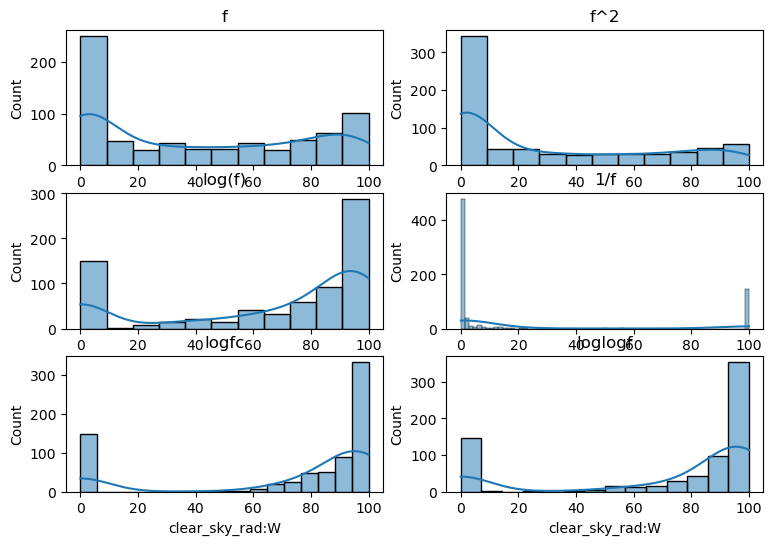

In [29]:
import seaborn as sns

i = 2
token = True

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 6))
axes = axes.flatten()
feature = X_new.iloc[:,i]#.resample('M').mean()

f = normalize(feature)*100
sns.histplot(data=f, ax=axes[0], kde=True)
axes[0].set_title("f")

f2 = normalize((feature)**2)*100
sns.histplot(data=f2, ax=axes[1], kde=True)
axes[1].set_title("f^2")

logf = normalize(np.log(feature+1))*100
sns.histplot(data=logf, ax=axes[2], kde=True)
axes[2].set_title("log(f)")

if token:
    f_1 = normalize(1/(feature+1))*100
    sns.histplot(data=f_1, ax=axes[3], kde=True)
    axes[3].set_title("1/f")


c = (feature.quantile(.25)/feature.quantile(.75))**2
logfc = normalize(np.log(feature+c))*100
sns.histplot(data=logfc, ax=axes[4], kde=True)
axes[4].set_title("logfc")

loglogf = normalize(np.log(np.log(feature+1)+1))*100
sns.histplot(data=loglogf, ax=axes[5], kde=True)
axes[5].set_title("loglogf")


print('mean',f.mean(),np.mean(f2), np.mean(logf), np.mean(f_1), np.mean(logfc), np.mean(loglogf))
print(f'var f:{np.var(f)}, f2:{np.var(f2)}, logf:{np.var(logf)}, f_1:{np.var(f_1)}, logfc:{np.var(logfc)}, loglogf:{np.var(loglogf)}')

In [30]:
transformations = [['absolute_humidity_2m:gm3', 'f'],
 ['air_density_2m:kgm3', '1/f'],
 ['ceiling_height_agl:m', 'f'],
 ['clear_sky_rad:W', 'f'],
 ['cloud_base_agl:m', 'logfc'],
 ['dew_or_rime:idx', 'hot'],
 ['effective_cloud_cover:p', 'f^2'],
 ['elevation:m', 'constant'],
 ['fresh_snow_12h:cm', 'loglogf ou rien'],
 ['fresh_snow_1h:cm', 'loglogf ou rien'],
 ['fresh_snow_24h:cm', 'loglogf ou rien'],
 ['fresh_snow_3h:cm', 'loglogf ou rien'],
 ['fresh_snow_6h:cm', 'loglogf ou rien'],
 ['is_day:idx', 'hot'],
 ['is_in_shadow:idx', 'hot'],
 ['precip_5min:mm', 'loglogf ou rien'],
 ['precip_type_5min:idx', 'hot'],
 ['pressure_100m:hPa', 'rien'],
 ['prob_rime:p', 'loglogf ou rien'],
 ['rain_water:kgm2', 'one hot à faire !'],
 ['relative_humidity_1000hPa:p', ''],
 ['snow_density:kgm3', 'constant'],
 ['snow_depth:cm', 'loglogf ou rien'],
 ['snow_drift:idx', 'hot'],
 ['snow_melt_10min:mm', 'loglogf ou rien'],
 ['snow_water:kgm2', 'loglogf ou rien'],
 ['sun_azimuth:d', 'f ou f^2'],
 ['sun_elevation:d', 'f ou f^2'],
 ['super_cooled_liquid_water:kgm2', 'loglogf ou rien'],
 ['t_1000hPa:K', 'f^2'],
 ['total_cloud_cover:p', 'f^2 ou rien'],
 ['visibility:m', 'f'],
 ['wind_speed_10m:ms', 'f ou logfc'],
 ['wind_speed_u_10m:ms', 'f ou logfc'],
 ['wind_speed_v_10m:ms', 'f'],
 ['wind_speed_w_1000hPa:ms', 'hot']]

In [31]:
'wind_speed_w_1000hPa:ms' in X_test_estimated_a.columns

True

In [32]:
for X in [X_train_estimated_a, X_train_observed_a, X_test_estimated_a,
         X_train_estimated_b, X_train_observed_b, X_test_estimated_b,
         X_train_estimated_c, X_train_observed_c, X_test_estimated_c]: 
    for feature, function in transformations:
        if feature in X.columns:
            if function == '1/f':
                X[feature] = 1/(X[feature]+1)
            if function == 'logfc':
                X[feature] = np.log(X[feature] + (X[feature].quantile(.25)/X[feature].quantile(.75))**2 )
            if function == 'f^2':
                X[feature] = (X[feature])**2
            if function == 'logf':
                X[feature] = np.log(X[feature]+1)
            if function == 'loglogf':
                X[feature] = np.log(np.log(X[feature]+1)+1)

/Applications/anaconda3/envs/tdt4173/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/anaconda3/envs/tdt4173/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/anaconda3/envs/tdt4173/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/anaconda3/envs/tdt4173/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/anaconda3/envs/tdt4173/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Applications/a

array([[<Axes: title={'center': 'air_density_2m:kgm3'}>,
        <Axes: title={'center': 'ceiling_height_agl:m'}>,
        <Axes: title={'center': 'clear_sky_rad:W'}>,
        <Axes: title={'center': 'cloud_base_agl:m'}>,
        <Axes: title={'center': 'dew_point_2m:K'}>,
        <Axes: title={'center': 'diffuse_rad:W'}>],
       [<Axes: title={'center': 'direct_rad:W'}>,
        <Axes: title={'center': 'effective_cloud_cover:p'}>,
        <Axes: title={'center': 'fresh_snow_12h:cm'}>,
        <Axes: title={'center': 'fresh_snow_1h:cm'}>,
        <Axes: title={'center': 'fresh_snow_24h:cm'}>,
        <Axes: title={'center': 'fresh_snow_3h:cm'}>],
       [<Axes: title={'center': 'fresh_snow_6h:cm'}>,
        <Axes: title={'center': 'is_day:idx'}>,
        <Axes: title={'center': 'msl_pressure:hPa'}>,
        <Axes: title={'center': 'precip_5min:mm'}>,
        <Axes: title={'center': 'prob_rime:p'}>,
        <Axes: title={'center': 'relative_humidity_1000hPa:p'}>],
       [<Axes: title=

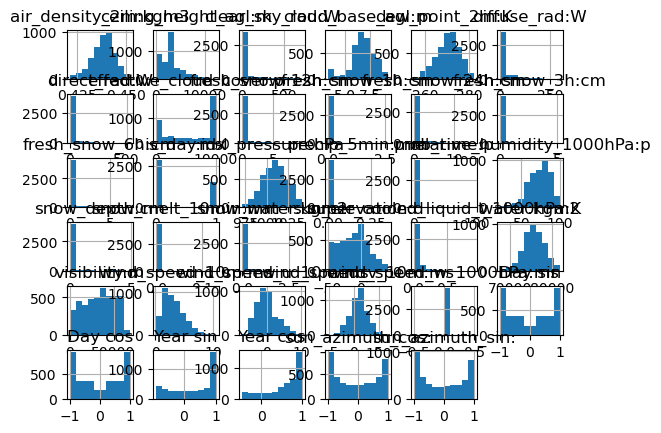

In [33]:
X_train_estimated_a.iloc[:,:].hist()

Transformation on y

Text(0.5, 1.0, 'log y>0')

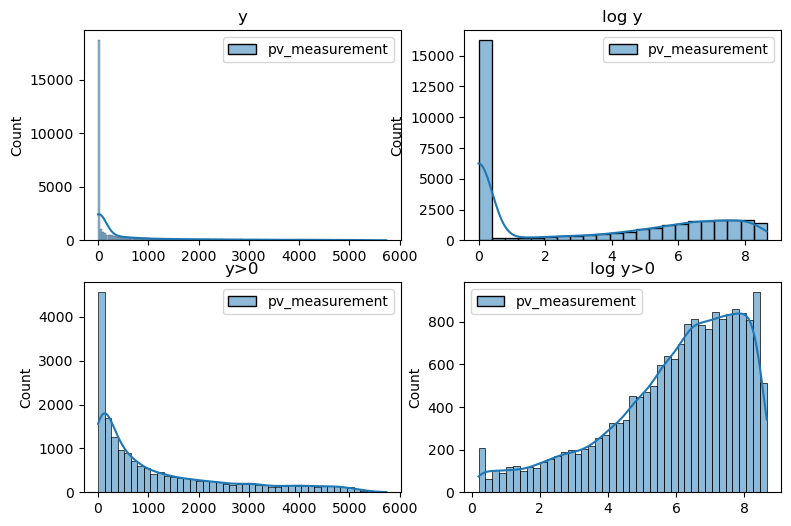

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
axes = axes.flatten()

sns.histplot(data=train_a, ax=axes[0], kde=True)
axes[0].set_title("y")

sns.histplot(data=(np.log(train_a + 1)), ax=axes[1], kde=True)
axes[1].set_title("log y")

sns.histplot(data=train_a[train_a>0], ax=axes[2], kde=True)
axes[2].set_title("y>0")

sns.histplot(data=(np.log(train_a[train_a>0] + 1)), ax=axes[3], kde=True)
axes[3].set_title("log y>0")

## Normalize (MinMax, StandardScaler, Robust)


In [35]:
col = []
for X in [X_train_estimated_a, X_train_observed_a, X_test_estimated_a,
         X_train_estimated_b, X_train_observed_b, X_test_estimated_b,
         X_train_estimated_c, X_train_observed_c, X_test_estimated_c]:
    col.append(X.columns)
    
id_ = []
for X in [X_train_estimated_a, X_train_observed_a, X_test_estimated_a,
         X_train_estimated_b, X_train_observed_b, X_test_estimated_b,
         X_train_estimated_c, X_train_observed_c, X_test_estimated_c]:
    id_.append(X.index)

In [36]:
#Normalisation 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()
X_train_estimated_a = scaler.fit_transform(X_train_estimated_a)
X_train_observed_a = scaler.fit_transform(X_train_observed_a)
X_test_estimated_a = scaler.fit_transform(X_test_estimated_a)

X_train_estimated_b = scaler.fit_transform(X_train_estimated_b)
X_train_observed_b = scaler.fit_transform(X_train_observed_b)
X_test_estimated_b = scaler.fit_transform(X_test_estimated_b)

X_train_estimated_c = scaler.fit_transform(X_train_estimated_c)
X_train_observed_c = scaler.fit_transform(X_train_observed_c)
X_test_estimated_c = scaler.fit_transform(X_test_estimated_c)

In [37]:
X_train_estimated_a = pd.DataFrame(X_train_estimated_a, columns=col[0], index=id_[0])
X_train_observed_a = pd.DataFrame(X_train_observed_a, columns=col[1], index=id_[1])
X_test_estimated_a = pd.DataFrame(X_test_estimated_a, columns=col[2], index=id_[2])

X_train_estimated_b = pd.DataFrame(X_train_estimated_b, columns=col[3], index=id_[3])
X_train_observed_b = pd.DataFrame(X_train_observed_b, columns=col[4], index=id_[4])
X_test_estimated_b = pd.DataFrame(X_test_estimated_b, columns=col[5], index=id_[5])

X_train_estimated_c = pd.DataFrame(X_train_estimated_c, columns=col[6], index=id_[6])
X_train_observed_c = pd.DataFrame(X_train_observed_c, columns=col[7], index=id_[7])
X_test_estimated_c = pd.DataFrame(X_test_estimated_c, columns=col[8], index=id_[8])

In [38]:
X_train_estimated_a.max().sort_values(ascending=True)[:10]

wind_speed_w_1000hPa:ms               0.0
rain_water:kgm2_0.8999999761581421    0.0
rain_water:kgm2_0.699999988079071     0.0
rain_water:kgm2_0.6000000238418579    0.0
rain_water:kgm2_0.5                   0.0
precip_type_5min:idx_6.0              0.0
precip_type_5min:idx_5.0              0.0
rain_water:kgm2_1.0                   0.0
rain_water:kgm2_1.399999976158142     0.0
wind_speed_10m:ms                     1.0
dtype: float64

## X_Estimated: Apply shift between estimated and observed

(0.23552274958107894, 0.25934261405682124)

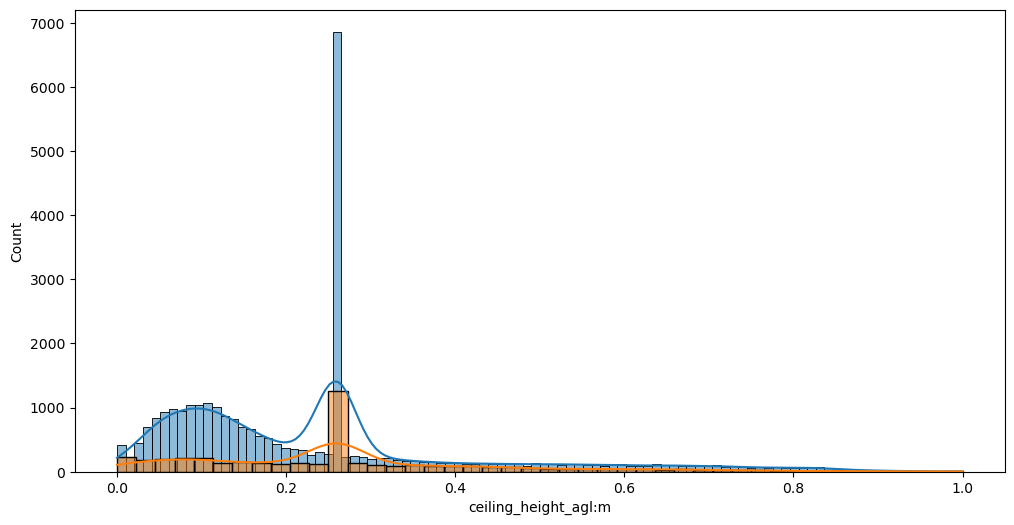

In [39]:
i = 1

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

#sns.histplot(data=X_train_observed_a_est.loc[A_index21_est].iloc[:,i], kde=True)
sns.histplot(data=X_train_observed_a.iloc[:,i], kde=True)
sns.histplot(data=X_train_estimated_a.iloc[:,i], kde=True)

X_train_observed_a.iloc[:,i].mean(), X_train_estimated_a.iloc[:,i].mean(), 

We create a function SHIFT, in order to have the same expected value and SD between observed and estimate for the same time-period (like spring).

In [40]:
def shift(X_obs, X_est):
    mu_obs, sd_obs = X_obs.mean(), np.sqrt(X_obs.var())
    mu_est, sd_est = X_est.mean(), np.sqrt(X_est.var())
    if sd_est>0:
        X_est = (X_est - mu_est) / sd_est
        X_est = (X_est * sd_obs) + mu_obs
        return X_est
    else:
        return X_est

We select lines from X_observed value for a specific time-period.

## SHIFT

### Test Estimated SHIFT Train Observed

In [41]:
X_test_estimated_a.index

DatetimeIndex(['2023-05-01 00:00:00', '2023-05-01 01:00:00',
               '2023-05-01 02:00:00', '2023-05-01 03:00:00',
               '2023-05-01 04:00:00', '2023-05-01 05:00:00',
               '2023-05-01 06:00:00', '2023-05-01 07:00:00',
               '2023-05-01 08:00:00', '2023-05-01 09:00:00',
               ...
               '2023-07-03 14:00:00', '2023-07-03 15:00:00',
               '2023-07-03 16:00:00', '2023-07-03 17:00:00',
               '2023-07-03 18:00:00', '2023-07-03 19:00:00',
               '2023-07-03 20:00:00', '2023-07-03 21:00:00',
               '2023-07-03 22:00:00', '2023-07-03 23:00:00'],
              dtype='datetime64[us]', name='date_forecast', length=720, freq=None)

In [42]:
A_index19 = X_train_observed_a.loc['2019-05-01 00:00:00':'2019-07-03 23:45:00'].index
A_index20 = X_train_observed_a.loc['2020-05-01 00:00:00':'2020-07-03 23:45:00'].index
A_index21 = X_train_observed_a.loc['2021-05-01 00:00:00':'2021-07-03 23:45:00'].index
A_index22 = X_train_observed_a.loc['2022-05-01 00:00:00':'2022-07-03 23:45:00'].index

B_index19 = X_train_observed_b.loc['2019-05-01 00:00:00':'2019-07-03 23:45:00'].index
B_index20 = X_train_observed_b.loc['2020-05-01 00:00:00':'2020-07-03 23:45:00'].index
B_index21 = X_train_observed_b.loc['2021-05-01 00:00:00':'2021-07-03 23:45:00'].index
#B_index22 = X_train_observed_b.loc['2022-05-01 00:00:00':'2022-07-03 23:45:00'].index

#C_index19 = X_train_observed_c.loc['2019-05-01 00:00:00':'2019-07-03 23:45:00'].index
C_index20 = X_train_observed_c.loc['2020-05-01 00:00:00':'2020-07-03 23:45:00'].index
C_index21 = X_train_observed_c.loc['2021-05-01 00:00:00':'2021-07-03 23:45:00'].index
#C_index22 = X_train_observed_c.loc['2022-05-01 00:00:00':'2022-07-03 23:45:00'].index

Problem : the first spring in 2019 for A is half empty.

In [43]:
len(C_index20),len(C_index21)

(1536, 1536)

In [44]:
len(A_index19),len(A_index20), len(B_index19)

(746, 1536, 1536)

In [45]:
A_index_spring = A_index20.union(A_index21).union(A_index22)
B_index_spring = B_index19.union(B_index20).union(B_index21)#.union(B_index22)
C_index_spring = C_index20.union(C_index21) #C_index19.union(C_index20).union(C_index21).union(C_index22)

In [46]:
X_train_observed_a_sping = X_train_observed_a.loc[A_index_spring]
X_train_observed_b_sping = X_train_observed_b.loc[B_index_spring]
X_train_observed_c_sping = X_train_observed_c.loc[C_index_spring]

<Axes: >

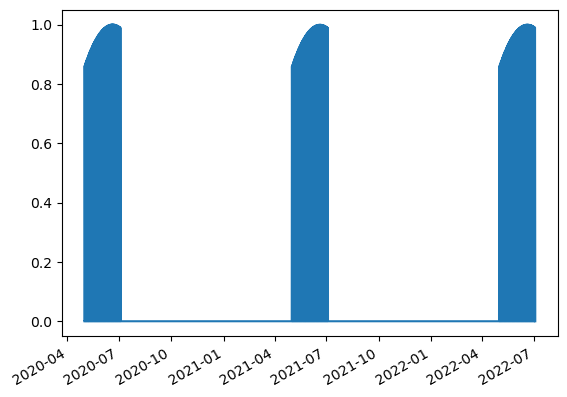

In [47]:
X_train_observed_a_sping.iloc[:,2].plot()

In [48]:
for i in range(X_test_estimated_a.shape[1]):
    X_obs, X_est = X_train_observed_a_sping.iloc[:,i], X_test_estimated_a.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_test_estimated_a.iloc[:,i] = X_est_new
    
for i in range(X_test_estimated_b.shape[1]):
    X_obs, X_est = X_train_observed_b_sping.iloc[:,i], X_test_estimated_b.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_test_estimated_b.iloc[:,i] = X_est_new
    
for i in range(X_test_estimated_c.shape[1]):
    X_obs, X_est = X_train_observed_c_sping.iloc[:,i], X_test_estimated_c.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_test_estimated_c.iloc[:,i] = X_est_new

MEAN  X_obs_spring 0.6722724347059863       X_test_shift 0.6722724347059863
VAR X_obs_spring 0.010384350050819398       X_test_shift 0.010384350050819436


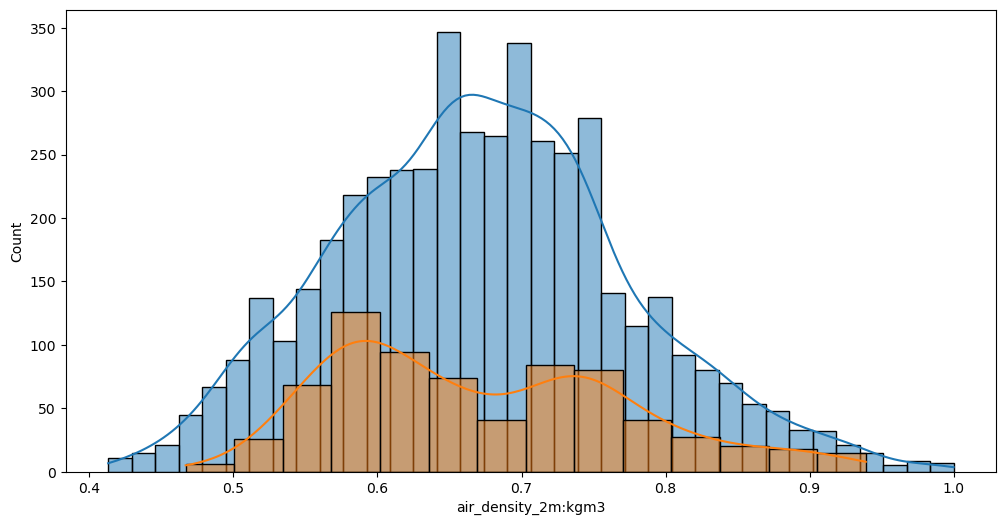

In [49]:
i = 0

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.histplot(data=X_train_observed_a_sping.iloc[:,i], kde=True)
sns.histplot(data=X_test_estimated_a.iloc[:,i], kde=True)

print(f'MEAN  X_obs_spring {X_train_observed_a_sping.iloc[:,i].mean()} \
      X_test_shift {X_test_estimated_a.iloc[:,i].mean()}')

print(f'VAR X_obs_spring {X_train_observed_a_sping.iloc[:,i].var()} \
      X_test_shift {X_test_estimated_a.iloc[:,i].var()}')

### Train Estimated SHIFT Train Observed

Same thing for X_train_estimated.

In [50]:
X_train_estimated_a.index

DatetimeIndex(['2022-10-28 22:00:00', '2022-10-28 23:00:00',
               '2022-10-29 00:00:00', '2022-10-29 01:00:00',
               '2022-10-29 02:00:00', '2022-10-29 03:00:00',
               '2022-10-29 04:00:00', '2022-10-29 05:00:00',
               '2022-10-29 06:00:00', '2022-10-29 07:00:00',
               ...
               '2023-04-30 14:00:00', '2023-04-30 15:00:00',
               '2023-04-30 16:00:00', '2023-04-30 17:00:00',
               '2023-04-30 18:00:00', '2023-04-30 19:00:00',
               '2023-04-30 20:00:00', '2023-04-30 21:00:00',
               '2023-04-30 22:00:00', '2023-04-30 23:00:00'],
              dtype='datetime64[us]', length=4394, freq=None)

In [51]:
A_index19_est = X_train_observed_a.loc['2019-10-28 22:00:00':'2020-04-30 23:00:00'].index
A_index20_est = X_train_observed_a.loc['2020-10-28 22:00:00':'2021-04-30 23:00:00'].index
A_index21_est = X_train_observed_a.loc['2021-10-28 22:00:00':'2022-04-30 23:00:00'].index

B_index19_est = X_train_observed_b.loc['2019-10-28 22:00:00':'2020-04-30 23:00:00'].index
B_index20_est = X_train_observed_b.loc['2020-10-28 22:00:00':'2021-04-30 23:00:00'].index
B_index21_est = X_train_observed_b.loc['2021-10-28 22:00:00':'2022-04-30 23:00:00'].index

C_index19_est = X_train_observed_c.loc['2019-10-28 22:00:00':'2020-04-30 23:00:00'].index
C_index20_est = X_train_observed_c.loc['2020-10-28 22:00:00':'2021-04-30 23:00:00'].index
C_index21_est = X_train_observed_c.loc['2021-10-28 22:00:00':'2022-04-30 23:00:00'].index

In [52]:
len(C_index19_est),len(C_index20_est), len(C_index21_est)

(4442, 4418, 4293)

In [53]:
A_index20_est

DatetimeIndex(['2020-10-28 22:00:00', '2020-10-28 23:00:00',
               '2020-10-29 00:00:00', '2020-10-29 01:00:00',
               '2020-10-29 02:00:00', '2020-10-29 03:00:00',
               '2020-10-29 04:00:00', '2020-10-29 05:00:00',
               '2020-10-29 06:00:00', '2020-10-29 07:00:00',
               ...
               '2021-04-30 14:00:00', '2021-04-30 15:00:00',
               '2021-04-30 16:00:00', '2021-04-30 17:00:00',
               '2021-04-30 18:00:00', '2021-04-30 19:00:00',
               '2021-04-30 20:00:00', '2021-04-30 21:00:00',
               '2021-04-30 22:00:00', '2021-04-30 23:00:00'],
              dtype='datetime64[us]', length=4418, freq=None)

In [54]:
A_index_est = A_index19_est.union(A_index20_est).union(A_index21_est)
B_index_est = B_index19_est.union(B_index20_est).union(B_index21_est)
C_index_est = C_index19_est.union(C_index20_est).union(C_index21_est)

In [55]:
X_train_observed_a_est = X_train_observed_a.loc[A_index_est]
X_train_observed_b_est = X_train_observed_b.loc[B_index_est]
X_train_observed_c_est = X_train_observed_c.loc[C_index_est]

<Axes: >

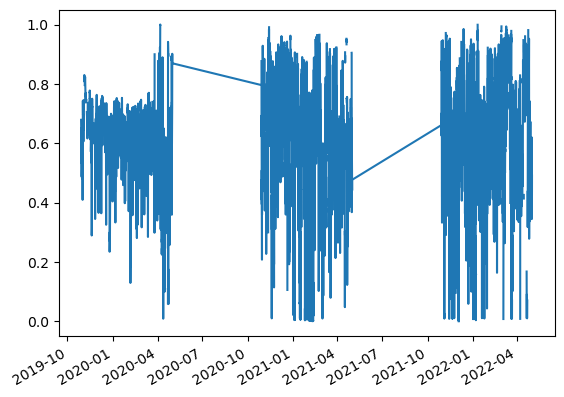

In [56]:
X_train_observed_a_est.iloc[:,3].plot()

In [57]:
for i in range(X_train_estimated_a.shape[1]):
    X_obs, X_est = X_train_observed_a_est.iloc[:,i], X_train_estimated_a.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_train_estimated_a.iloc[:,i] = X_est_new
    
for i in range(X_train_estimated_b.shape[1]):
    X_obs, X_est = X_train_observed_b_est.iloc[:,i], X_train_estimated_b.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_train_estimated_b.iloc[:,i] = X_est_new
    
for i in range(X_train_estimated_c.shape[1]):
    X_obs, X_est = X_train_observed_b_est.iloc[:,i], X_train_estimated_c.iloc[:,i]
    X_est_new = shift(X_obs, X_est)
    X_train_estimated_c.iloc[:,i] = X_est_new

MEAN  X_obs_est 0.5100112545821068       X_train_est_shift 0.5100112545821068
VAR X_obs_est 0.011914159600729234       X_train_est_shift 0.011914159600729318


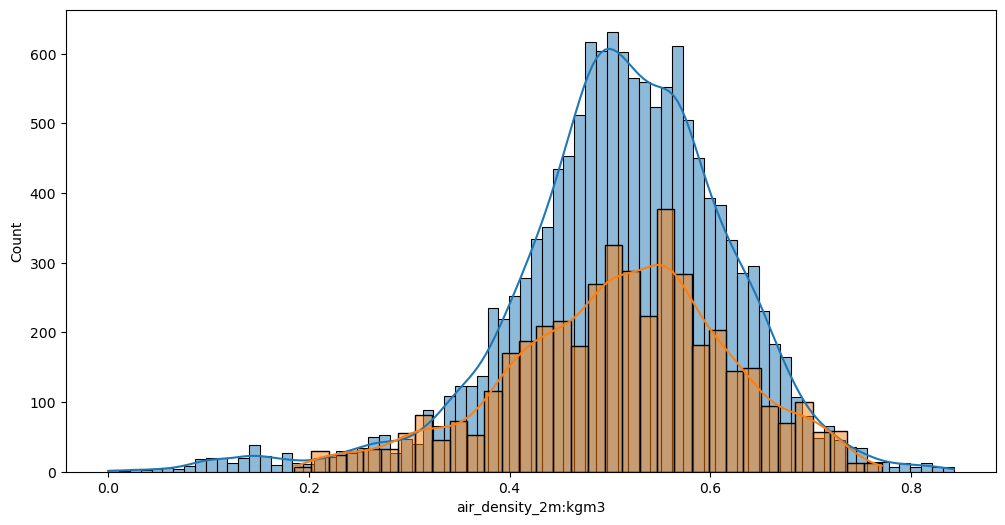

In [58]:
i = 0

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.histplot(data=X_train_observed_a_est.iloc[:,i], kde=True)
sns.histplot(data=X_train_estimated_a.iloc[:,i], kde=True)

print(f'MEAN  X_obs_est {X_train_observed_a_est.iloc[:,i].mean()} \
      X_train_est_shift {X_train_estimated_a.iloc[:,i].mean()}')

print(f'VAR X_obs_est {X_train_observed_a_est.iloc[:,i].var()} \
      X_train_est_shift {X_train_estimated_a.iloc[:,i].var()}')

# 5. ImBalance Data (too much zero to forecast)
- Build 2 models, one binary classification, and another one for y>0 prediction

We create train_S_estimated_binary, train_S_observed_binary which indicates if y>0 of not.

In [59]:
max_a = max(train_a_estimated['pv_measurement'])
train_a_estimated['pv_measurement'] = train_a_estimated['pv_measurement']/max_a

max_b = max(train_b_estimated['pv_measurement'])
train_b_estimated['pv_measurement'] = train_b_estimated['pv_measurement']/max_b

max_c = max(train_c_estimated['pv_measurement'])
train_c_estimated['pv_measurement'] = train_c_estimated['pv_measurement']/max_c

In [60]:
train_a_observed['pv_measurement'] = train_a_observed['pv_measurement']/max_a

train_b_observed['pv_measurement'] = train_b_observed['pv_measurement']/max_b

train_c_observed['pv_measurement'] = train_c_observed['pv_measurement']/max_c

In [61]:
X_train_total_a = pd.concat([X_train_observed_a, X_train_estimated_a, X_test_estimated_a], axis=0)
y_train_total_a = pd.concat([train_a_observed, train_a_estimated], axis=0)

X_train_total_b = pd.concat([X_train_observed_b, X_train_estimated_b, X_test_estimated_b], axis=0)
y_train_total_b = pd.concat([train_b_observed, train_b_estimated], axis=0)

X_train_total_c = pd.concat([X_train_observed_c, X_train_estimated_c, X_test_estimated_c], axis=0)
y_train_total_c = pd.concat([train_c_observed, train_c_estimated], axis=0)

In [62]:
from datetime import datetime

def transform_date_to_string(date):
    date_datetime = datetime.utcfromtimestamp(date.timestamp())
    date_string = date_datetime.strftime('%Y-%m-%d %H:%M:%S')
    return date_string 

def transform_date_to_timestamp(date) : 
    date_datetime = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    date_timestamp = date_datetime.timestamp()
    return date_timestamp

def dico_means(df_total, df_y, df_observed, df_estimated, df_test):
    dico_means = {}
    for date in df_total.index : 
        if date not in dico_means.keys():
            date = transform_date_to_string(date)
            date_2019 = '2019' + date[4::]
            date_2020 = '2020' + date[4::]
            date_2021 = '2021' + date[4::]
            date_2022 = '2022' + date[4::]
            date_2023 = '2023' + date[4::]
            
            date_list = [date_2019, date_2020, date_2021, date_2022, date_2023]
            date_in_y = [0, 0, 0, 0, 0]
            
            for i in range(5) : 
                if date_list[i] in df_y.index : 
                    date_in_y[i] = 1
            
            
            dates_to_mean = [date_list[i] for i in np.where(np.array(date_in_y) == 1)[0]]
            mean_value = df_y.loc[dates_to_mean].mean()['pv_measurement']
            
            dico_means[date_2019] = mean_value
            dico_means[date_2020] = mean_value
            dico_means[date_2021] = mean_value
            dico_means[date_2022] = mean_value
            dico_means[date_2023] = mean_value
    
    to_add_observed = []
    to_add_estimated = []
    to_add_test = []
    
    for date in sorted(dico_means.keys()) : 
        if date in df_observed.index : 
            to_add_observed.append(dico_means[date])
        if date in df_estimated.index : 
            to_add_estimated.append(dico_means[date])
        if date in df_test.index : 
            to_add_test.append(dico_means[date])
            
    df_observed['y_mean'] = to_add_observed
    df_estimated['y_mean'] = to_add_estimated
    df_test['y_mean'] = to_add_test

In [63]:
dico_means(X_train_total_a, y_train_total_a, X_train_observed_a, X_train_estimated_a, X_test_estimated_a)
dico_means(X_train_total_b, y_train_total_b, X_train_observed_b, X_train_estimated_b, X_test_estimated_b)
dico_means(X_train_total_c, y_train_total_c, X_train_observed_c, X_train_estimated_c, X_test_estimated_c)

In [64]:
X_test_estimated_b[24:48].y_mean

date_forecast
2023-05-06 00:00:00    0.000000
2023-05-06 01:00:00    0.000000
2023-05-06 02:00:00    0.000000
2023-05-06 03:00:00    0.019711
2023-05-06 04:00:00    0.079514
2023-05-06 05:00:00    0.250236
2023-05-06 06:00:00    0.522187
2023-05-06 07:00:00    0.657495
2023-05-06 08:00:00    0.779105
2023-05-06 09:00:00    0.863630
2023-05-06 10:00:00    0.854944
2023-05-06 11:00:00    0.741686
2023-05-06 12:00:00    0.844921
2023-05-06 13:00:00    0.695582
2023-05-06 14:00:00    0.634108
2023-05-06 15:00:00    0.433653
2023-05-06 16:00:00    0.274624
2023-05-06 17:00:00    0.133303
2023-05-06 18:00:00    0.061807
2023-05-06 19:00:00    0.008352
2023-05-06 20:00:00    0.000000
2023-05-06 21:00:00    0.000000
2023-05-06 22:00:00    0.000000
2023-05-06 23:00:00    0.000000
Name: y_mean, dtype: float64

In [65]:
# We modify Y to have a binary classification : 0 = no production of electricity
train_a_estimated_binary = pd.DataFrame({'pv_measurement' : train_a_estimated['pv_measurement']})
train_a_observed_binary = pd.DataFrame({'pv_measurement' : train_a_observed['pv_measurement']})

train_b_estimated_binary = pd.DataFrame({'pv_measurement' : train_b_estimated['pv_measurement']})
train_b_observed_binary = pd.DataFrame({'pv_measurement' : train_b_observed['pv_measurement']})

train_c_estimated_binary = pd.DataFrame({'pv_measurement' : train_c_estimated['pv_measurement']})
train_c_observed_binary = pd.DataFrame({'pv_measurement' : train_c_observed['pv_measurement']})

for time in train_a_estimated_binary.index:
    if train_a_estimated_binary.loc[time]['pv_measurement'] > 0 :
        train_a_estimated_binary.loc[time] = 1

for time in train_a_observed_binary.index:
    if train_a_observed_binary.loc[time]['pv_measurement'] > 0 :
        train_a_observed_binary.loc[time] = 1  
        
for time in train_b_estimated_binary.index:
    if train_b_estimated_binary.loc[time]['pv_measurement'] > 0 :
        train_b_estimated_binary.loc[time] = 1

for time in train_b_observed_binary.index:
    if train_b_observed_binary.loc[time]['pv_measurement'] > 0 :
        train_b_observed_binary.loc[time] = 1 
        
for time in train_c_estimated_binary.index:
    if train_c_estimated_binary.loc[time]['pv_measurement'] > 0 :
        train_c_estimated_binary.loc[time] = 1

for time in train_c_observed_binary.index:
    if train_c_observed_binary.loc[time]['pv_measurement'] > 0 :
        train_c_observed_binary.loc[time] = 1 

<Axes: >

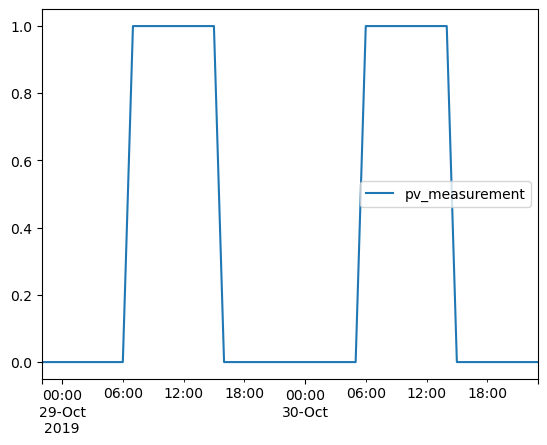

In [66]:
train_a_observed_binary.loc['2019-10-28 22:00:00':'2019-10-30 23:00:00'].plot()

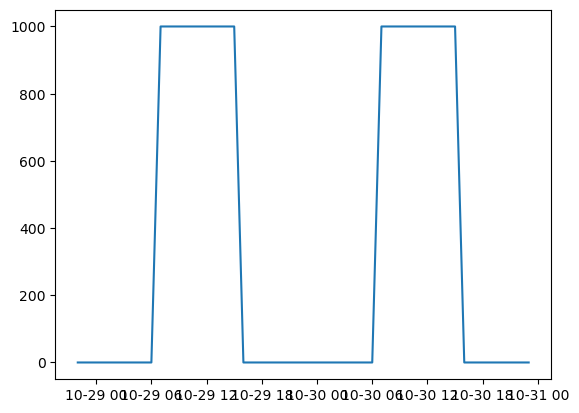

In [67]:
plt.plot(X_train_observed_a['is_day:idx'].loc['2019-10-28 22:00:00':'2019-10-30 23:00:00']*1000, label='Binary y')

In [68]:
#Missing values
value={'ceiling_height_agl:m' : X_train_estimated_a['ceiling_height_agl:m'].mean(),
       'cloud_base_agl:m' : -999#X_train_estimated_a['cloud_base_agl:m'].mean()
      }

X_train_estimated_a = X_train_estimated_a.fillna(value=value)
X_train_observed_a = X_train_observed_a.fillna(value=value)
X_test_estimated_a = X_test_estimated_a.fillna(value=value)

X_train_estimated_b = X_train_estimated_b.fillna(value=value)
X_train_observed_b = X_train_observed_b.fillna(value=value)
X_test_estimated_b = X_test_estimated_b.fillna(value=value)

X_train_estimated_c = X_train_estimated_c.fillna(value=value)
X_train_observed_c = X_train_observed_c.fillna(value=value)
X_test_estimated_c = X_test_estimated_c.fillna(value=value)

# Prediction for each station

## Location A, B, C

In [82]:
y_a_predict = X_test_estimated_a.loc[X_test_estimated_a.index].y_mean
df_pred_a = pd.DataFrame({'prediction' :y_a_predict})

# Transform the dataFrame of the prediction, to obtain the right file to submit
df_pred_a['location'] = ['A' for i in df_pred_a.index]
df_pred_a.reset_index(inplace = True)
df_pred_a.reset_index(inplace = True)
df_pred_a.columns = ['id', 'time', 'prediction', 'location']
df_pred_a

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.000000,A
1,1,2023-05-01 01:00:00,0.000000,A
2,2,2023-05-01 02:00:00,0.000000,A
3,3,2023-05-01 03:00:00,0.006181,A
4,4,2023-05-01 04:00:00,0.022683,A
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.035843,A
716,716,2023-07-03 20:00:00,0.010016,A
717,717,2023-07-03 21:00:00,0.000425,A
718,718,2023-07-03 22:00:00,0.000000,A


In [83]:
y_c_predict = X_test_estimated_c.loc[X_test_estimated_c.index].y_mean
df_pred_c = pd.DataFrame({'prediction' :y_c_predict})

# Transform the dataFrame of the prediction, to obtain the right file to submit
df_pred_c['location'] = ['C' for i in df_pred_c.index]
df_pred_c.reset_index(inplace = True)
df_pred_c.reset_index(inplace = True)
df_pred_c.columns = ['id', 'time', 'prediction', 'location']
df_pred_c

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.000000,C
1,1,2023-05-01 01:00:00,0.000000,C
2,2,2023-05-01 02:00:00,0.000000,C
3,3,2023-05-01 03:00:00,0.005482,C
4,4,2023-05-01 04:00:00,0.038377,C
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.049342,C
716,716,2023-07-03 20:00:00,0.010965,C
717,717,2023-07-03 21:00:00,0.000000,C
718,718,2023-07-03 22:00:00,0.000000,C


In [79]:
y_b_predict = X_test_estimated_b.loc[X_test_estimated_b.index].y_mean

In [80]:
df_pred_b = pd.DataFrame({'prediction' :y_b_predict})

In [81]:
# Transform the dataFrame of the prediction, to obtain the right file to submit
df_pred_b['location'] = ['B' for i in df_pred_b.index]
df_pred_b.reset_index(inplace = True)
df_pred_b.reset_index(inplace = True)
df_pred_b.columns = ['id', 'time', 'prediction', 'location']
df_pred_b

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.079431,B
1,1,2023-05-01 01:00:00,0.079431,B
2,2,2023-05-01 02:00:00,0.079431,B
3,3,2023-05-01 03:00:00,0.080182,B
4,4,2023-05-01 04:00:00,0.096970,B
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.147001,B
716,716,2023-07-03 20:00:00,0.122612,B
717,717,2023-07-03 21:00:00,0.121944,B
718,718,2023-07-03 22:00:00,0.121944,B


# Gather all the predictions

In [84]:
df_pred_a.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.000000,A
1,1,2023-05-01 01:00:00,0.000000,A
2,2,2023-05-01 02:00:00,0.000000,A
3,3,2023-05-01 03:00:00,0.006181,A
4,4,2023-05-01 04:00:00,0.022683,A


In [85]:
df_pred_b.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.079431,B
1,1,2023-05-01 01:00:00,0.079431,B
2,2,2023-05-01 02:00:00,0.079431,B
3,3,2023-05-01 03:00:00,0.080182,B
4,4,2023-05-01 04:00:00,0.096970,B


In [86]:
df_pred_c.head()

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.000000,C
1,1,2023-05-01 01:00:00,0.000000,C
2,2,2023-05-01 02:00:00,0.000000,C
3,3,2023-05-01 03:00:00,0.005482,C
4,4,2023-05-01 04:00:00,0.038377,C


In [87]:
df_pred_total = pd.concat([df_pred_a, df_pred_b, df_pred_c], axis = 0)
df_pred_final = pd.DataFrame({'id' : [i for i in range(2160)], 'prediction' : df_pred_total['prediction'].to_numpy()})
df_pred_total
#df_pred_final[0:100]

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0.000000,A
1,1,2023-05-01 01:00:00,0.000000,A
2,2,2023-05-01 02:00:00,0.000000,A
3,3,2023-05-01 03:00:00,0.006181,A
4,4,2023-05-01 04:00:00,0.022683,A
...,...,...,...,...
715,715,2023-07-03 19:00:00,0.049342,C
716,716,2023-07-03 20:00:00,0.010965,C
717,717,2023-07-03 21:00:00,0.000000,C
718,718,2023-07-03 22:00:00,0.000000,C


In [88]:
df_pred_final.to_csv('submission_21.csv', index=False)